In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
from pyspark.sql import SparkSession
          
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [110]:
spark = SparkSession.builder.appName('Read the file as dataframe.').getOrCreate()
test_data = spark.read.csv('test.csv', sep = ',', inferSchema = True, header = True)
 
test_data.printSchema()

#test_data.count()

root
 |-- Rand: double (nullable = true)
 |-- Flag: integer (nullable = true)
 |-- Value: integer (nullable = true)



In [111]:
#Dataframe - pandas

df = test_data.toPandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Rand    100000 non-null  float64
 1   Flag    100000 non-null  int32  
 2   Value   100000 non-null  int32  
dtypes: float64(1), int32(2)
memory usage: 1.5 MB


<Axes: ylabel='Density'>

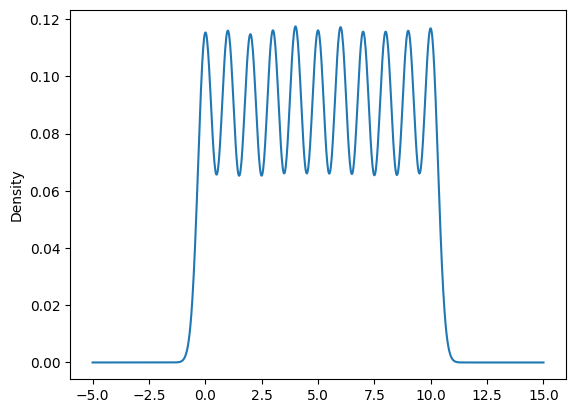

In [121]:
#plt.hist(df['Value'], cumulative = True, density = True) 
df['Value'].plot.kde()                  #kernel density estimate

<Axes: ylabel='Density'>

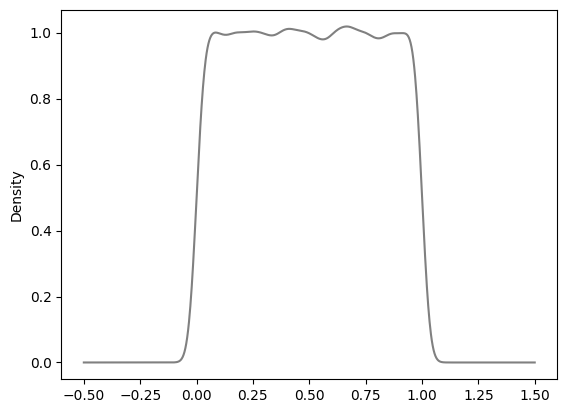

In [122]:
df['Rand'].plot.kde(color = 'gray')  

Flag
1    80053
0    19947
Name: count, dtype: int64


([<matplotlib.axis.XTick at 0x7a6d44ac96f0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

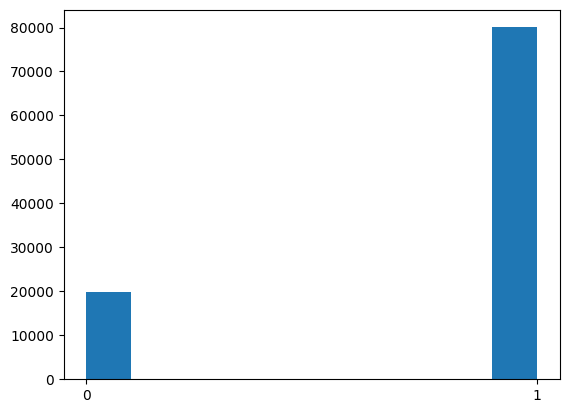

In [128]:
print(df['Flag'].value_counts())
df['Flag'].hist()
plt.grid(visible = False)
plt.xticks(range(0, 2, 1))

**Although there's imbalance (~80% of 1s versus ~20% of 0s) in the target variable which can be treated either by oversampling or undersampling of train data, I'm skipping either data resampling strategy for reasons that will be clear as I proceed.** 

In [130]:
#loaded spark dataset

test_data = test_data.select('Flag', 'Value')
test_data.printSchema()

root
 |-- Flag: integer (nullable = true)
 |-- Value: integer (nullable = true)



In [131]:
# Vectorizing data into a new column "features", which is input/features class 
assembler = VectorAssembler(inputCols = ['Value'], outputCol = 'features') 

#create the pipeline 
pipe = Pipeline(stages = [assembler]) 

#fit on dataset 
fit_model = pipe.fit(test_data) 
  
test_data = fit_model.transform(test_data)  
test_data.printSchema()

root
 |-- Flag: integer (nullable = true)
 |-- Value: integer (nullable = true)
 |-- features: vector (nullable = true)



In [132]:
#split data into training (80%) and testing (20%) subsets

train, test = test_data.randomSplit([0.8, 0.2], seed = 42)
print("Training Dataset: " + str(train.count()))
print("Test Dataset: " + str(test.count()))

Training Dataset: 79901
Test Dataset: 20099


In [133]:
#model object
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'Flag') 

#train model
lrModel = log_reg.fit(train)

In [134]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

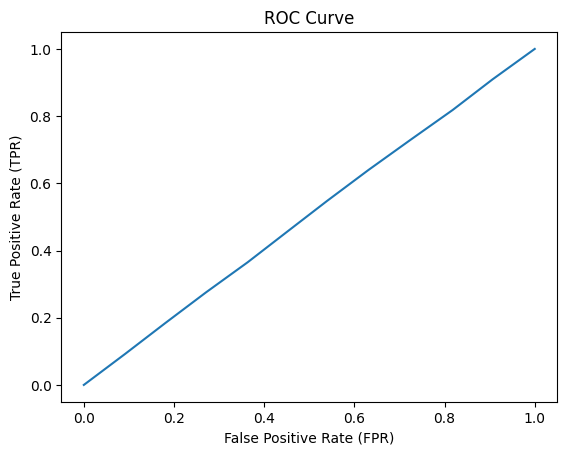

AUC-ROC (train) = 0.5036495614186751


In [137]:
#plot ROC curve for trained model assessment

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.title('ROC Curve')
plt.show()

print('AUC-ROC (train) = ' + str(trainingSummary.areaUnderROC))

The ROC (receiver operating characteristics) curve is a plot of TPR as a function of FPR as seen. It assesses the model - a diagonal divides the ROC space which represents a random classifier. Points above the diagonal represent good classification (better than random).

**It is clear from the curve above that the model built for the given dataset is a random classifier wherein, area under curve (AUC) is 0.5, representing randomness of the data which is quite intuitive (from a visual inspection of the data with columns, rand, flag, and value).**

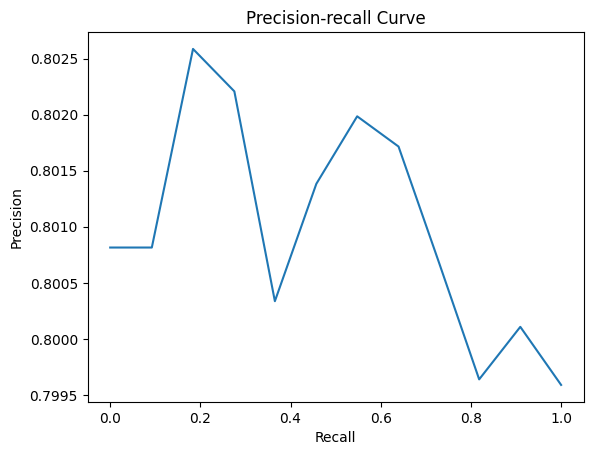

In [140]:
met = trainingSummary.pr.toPandas()
#print(met)

plt.plot(met['recall'], met['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-recall Curve')
plt.show()

**The AUC-ROC summarizes sensitivity and specificity (true negative rate), but does not yield classifier precision and hence, the above plot. This plot confirms the randomness of the dataset, having no predictive power.**

Precision measures the number of true positives out of all predicted positives, and **recall (sensitivity or true positive rate)** measures the number of true positives out of all actual positives. The ROC curve is the probability of detection versus probability of false alarm (false positive rate which is a type I error). 

These metrics together yield insights about the model performance. 

In [139]:
#use model to predict on test subset

lrPred = lrModel.transform(test)
lrPred.show(10)

+----+-----+--------+--------------------+--------------------+----------+
|Flag|Value|features|       rawPrediction|         probability|prediction|
+----+-----+--------+--------------------+--------------------+----------+
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
|   0|    0|   [0.0]|[-1.3637005249304...|[0.20363952823709...|       1.0|
+----+-----+--------+----

In [141]:
#model evaluation

res =  BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol = 'Flag') 
auc_roc = res.evaluate(lrPred)
print('AUC-ROC (test) = ', auc_roc)

AUC-ROC (test) =  0.5


Even if we had used the entire (100% or lesser/higher than 80%) dataset to train the model, the results would be same.  